**Environment Setup**

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

DATA_DIR = "./data"
BATCH_SIZE = 128
NUM_WORKERS = 2
SEED = 42
EPOCHS = 10

torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


**Preprocessing**

In [ ]:
# CIFAR-10 images are resized to 224×224 to stay compatible
# with ImageNet-pretrained backbones used later
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


**CIFAR-10 Dataset Loading**

In [ ]:
full_train_dataset = datasets.CIFAR10(
    root=DATA_DIR,
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root=DATA_DIR,
    train=False,
    download=True,
    transform=transform
)


100%|██████████| 170M/170M [01:25<00:00, 1.99MB/s]


**Train / Validation Split**

In [ ]:
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# 80–20 split of training data for validation
# a fixed random seed is used to ensure reproducibility

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(SEED)
)


**DataLoader Configuration**

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)


Train size: 40000
Val size: 10000
Test size: 10000
Batch shape: torch.Size([128, 3, 224, 224])


**Baseline Model Architecture (ResNet-18)**

In [ ]:
import torchvision.models as models

# ResNet-18 chosen as a lightweight baseline:
# balances capacity and training speed on CIFAR-10
model = models.resnet18(pretrained=True)

# replace classifier head to match CIFAR-10 classes
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


**Training and Evaluation Utilities**

In [ ]:
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


**Training**

In [ ]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(
        f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )


100%|██████████| 313/313 [02:03<00:00,  2.54it/s]


Epoch [1/10] | Train Loss: 0.5030, Train Acc: 0.8269 | Val Loss: 0.4426, Val Acc: 0.8525


100%|██████████| 313/313 [02:04<00:00,  2.52it/s]


Epoch [2/10] | Train Loss: 0.2765, Train Acc: 0.9059 | Val Loss: 0.3565, Val Acc: 0.8781


100%|██████████| 313/313 [02:04<00:00,  2.51it/s]


Epoch [3/10] | Train Loss: 0.1801, Train Acc: 0.9382 | Val Loss: 0.3419, Val Acc: 0.8888


100%|██████████| 313/313 [02:04<00:00,  2.52it/s]


Epoch [4/10] | Train Loss: 0.1255, Train Acc: 0.9574 | Val Loss: 0.3841, Val Acc: 0.8842


100%|██████████| 313/313 [02:04<00:00,  2.51it/s]


Epoch [5/10] | Train Loss: 0.0983, Train Acc: 0.9664 | Val Loss: 0.3473, Val Acc: 0.8984


100%|██████████| 313/313 [02:04<00:00,  2.52it/s]


Epoch [6/10] | Train Loss: 0.0722, Train Acc: 0.9753 | Val Loss: 0.3393, Val Acc: 0.9050


100%|██████████| 313/313 [02:04<00:00,  2.51it/s]


Epoch [7/10] | Train Loss: 0.0625, Train Acc: 0.9778 | Val Loss: 0.3742, Val Acc: 0.8980


100%|██████████| 313/313 [02:04<00:00,  2.52it/s]


Epoch [8/10] | Train Loss: 0.0616, Train Acc: 0.9791 | Val Loss: 0.3548, Val Acc: 0.9018


100%|██████████| 313/313 [02:03<00:00,  2.53it/s]


Epoch [9/10] | Train Loss: 0.0523, Train Acc: 0.9819 | Val Loss: 0.3399, Val Acc: 0.9074


100%|██████████| 313/313 [02:04<00:00,  2.52it/s]


Epoch [10/10] | Train Loss: 0.0531, Train Acc: 0.9821 | Val Loss: 0.3093, Val Acc: 0.9148


**Final Evaluation**

In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Final Test Accuracy (Level-1): {test_acc:.4f}")


Final Test Accuracy (Level-1): 0.9063


**Training Visualization**

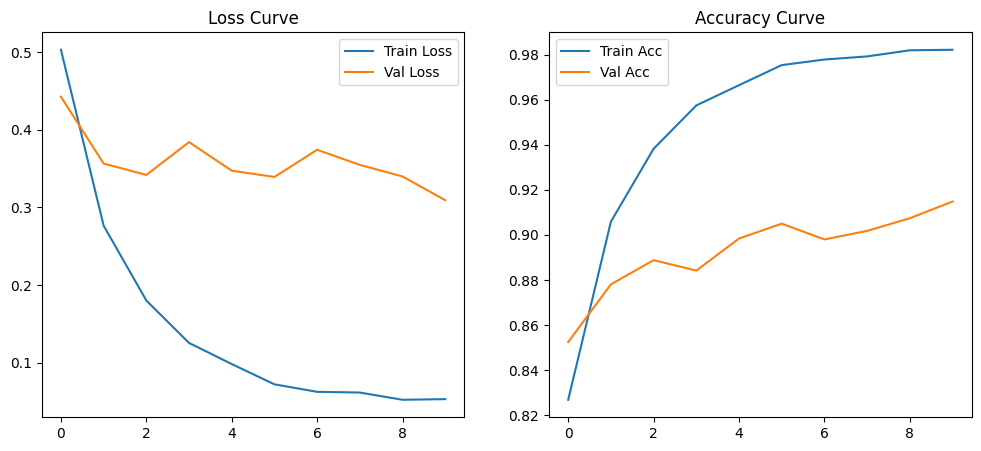

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.title("Accuracy Curve")

plt.show()
